In [1]:
# Small project during Physical Biology of the Cell(PBoC) at Gwangju Institute
# Science and Technology(GIST).
# In this project, I analyzed 2 freely diffusing bacteria and 1 bacteria that is
# being chased by a neutrophil.
# The first bacteria movie was obtained at GIST by diluting E. coli in growth media.
# The second and third bacteria were taken from David Rogers (Vanderbilt Univ.)
# 1950 neutrophil chase movie.
# Coded by Yongseok Choi at GIST and advised by Griffin Chure at Caltech.

# Import necessary tools
import glob
import os
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd

# BE/Bi 103 utilities
import bebi103

# Image processing tools
import skimage
import skimage.io
import skimage.morphology
import skimage.segmentation

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/Rio/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Directory containing the image files
data_dir = "/Users/Rio/Documents/2015-16_winter/PBoC@GIST/Project/free_diffusion/tiffs"

# Information about the first bacteria movie
fps = 7
time = 1/fps # in seconds
inter_pixel_distance = 160 # in nm

# Glob string for first movie images
im_glob = os.path.join(data_dir, 'new_diffusiont*.tif')

# Get list of files in directory
im_list = glob.glob(im_glob)

In [3]:
# Return only the R channel since RGB channels are all the same.
# This function also only selects region of interest (ROI) for bacteria 1 in movie 1.
def squish_rgb_and_show_ROI(fname):
    return skimage.io.imread(fname)[200:300,300:400,0]

# Image collection of only the R channel and ROI for bacteria 1.
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, load_func=squish_rgb_and_show_ROI)

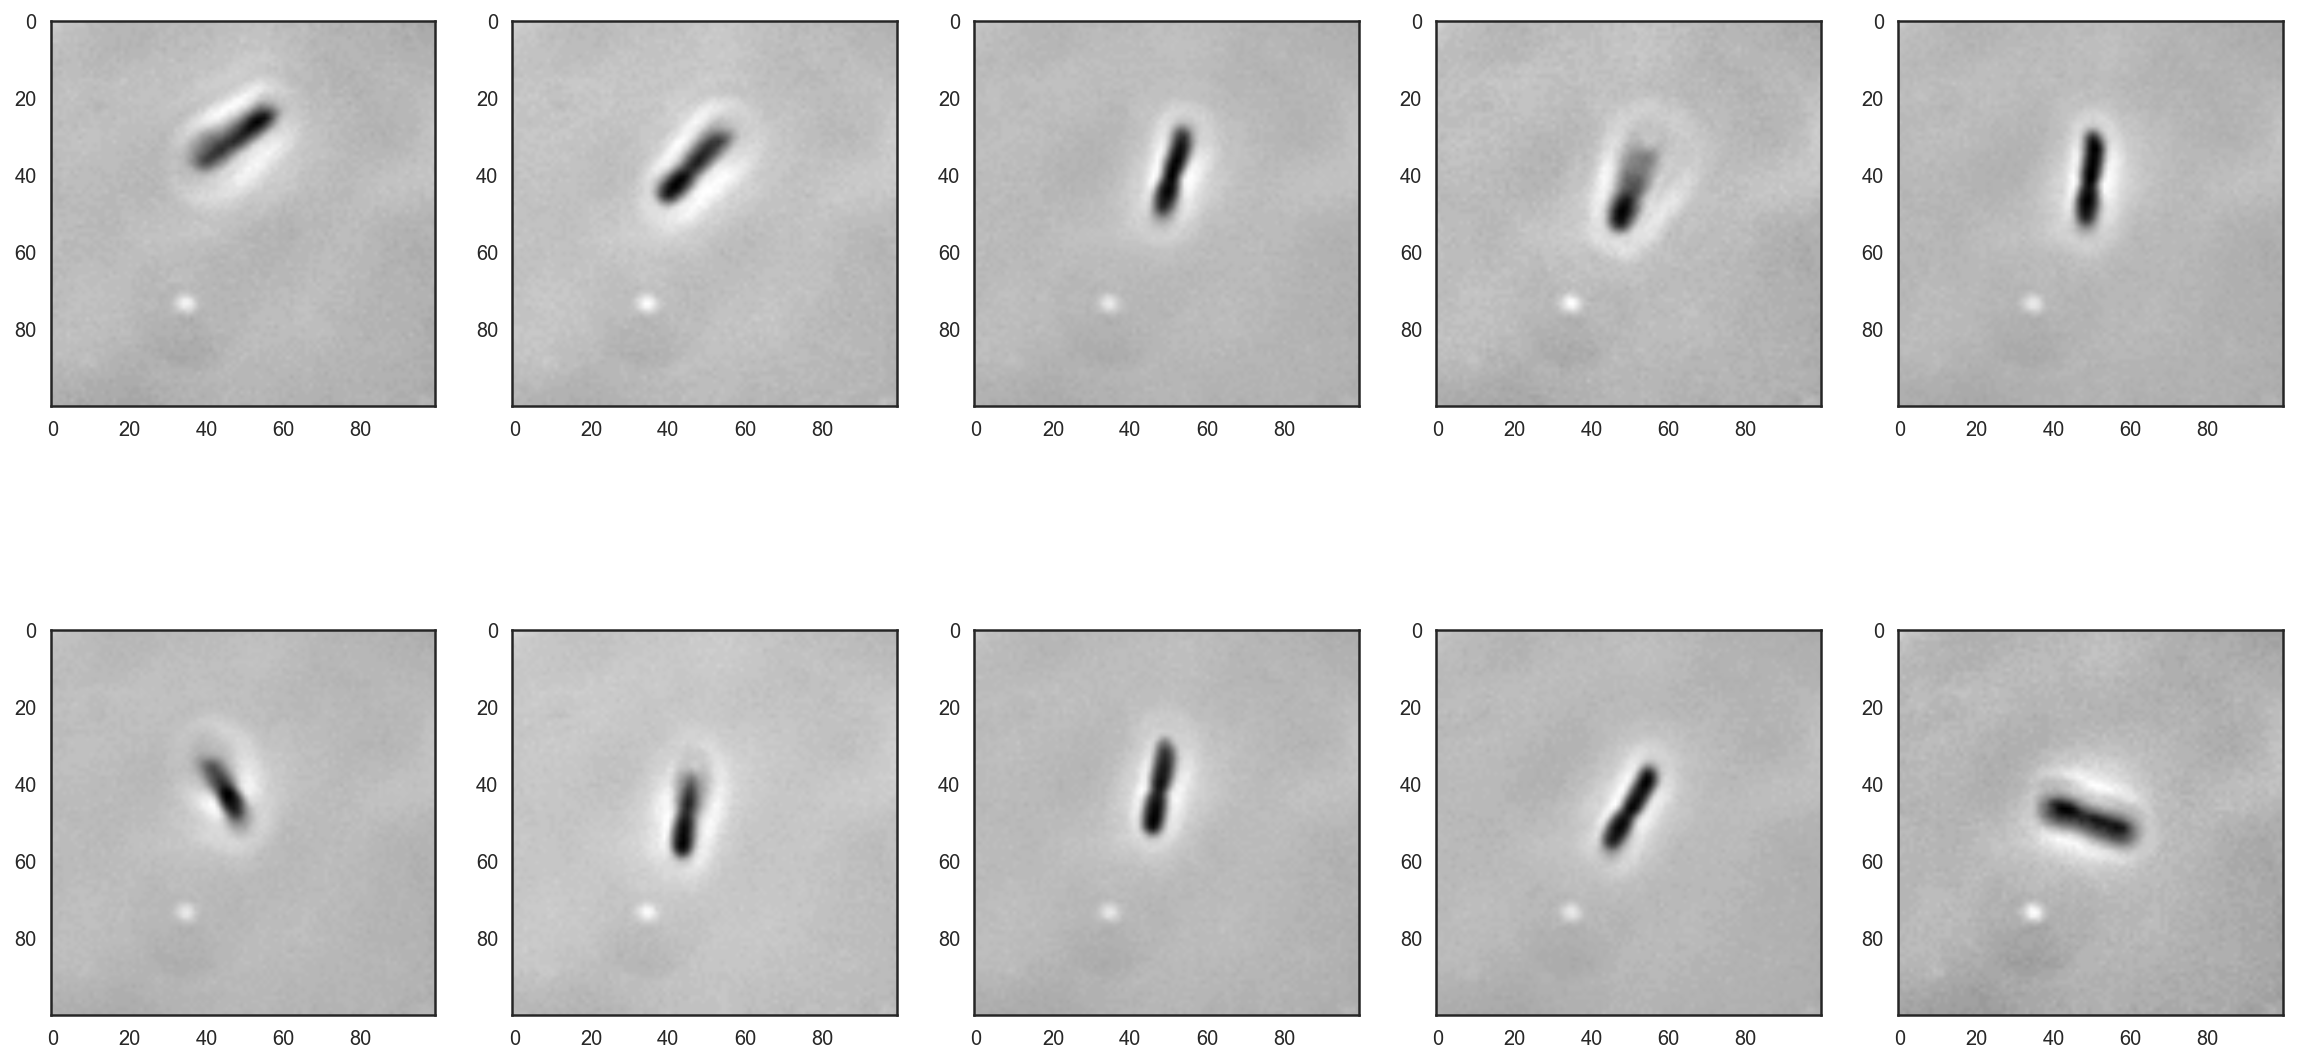

In [4]:
# I decided to choose frames 100 through 200.
# See them for every 10 frames before proceeding further
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 5, figsize=(20,10))
    for i in range(10):
        if i < 5:
            ax[0, i].imshow(ic[99 + i*10], cmap=plt.cm.gray)
        else:
            ax[1, i%5].imshow(ic[99 + i*10], cmap=plt.cm.gray)

In [5]:
centroid = [] # Empty list to store centroid coordinates
im_bw_labeled = [] # Empty list to store labeled images

# Threshold 100 frames from frame 100 to 200, label them and get the centroid with regionprops.
frame = 101
for i in range(99, 200):
    threshold = 100 # Decided by looking at the histogram of ic[138] and the actual array numbers
    im_bw_labeled.append(skimage.measure.label(ic[i] < threshold))
    props = skimage.measure.regionprops(im_bw_labeled[i - 99])
    centroid.append(props[0].centroid)

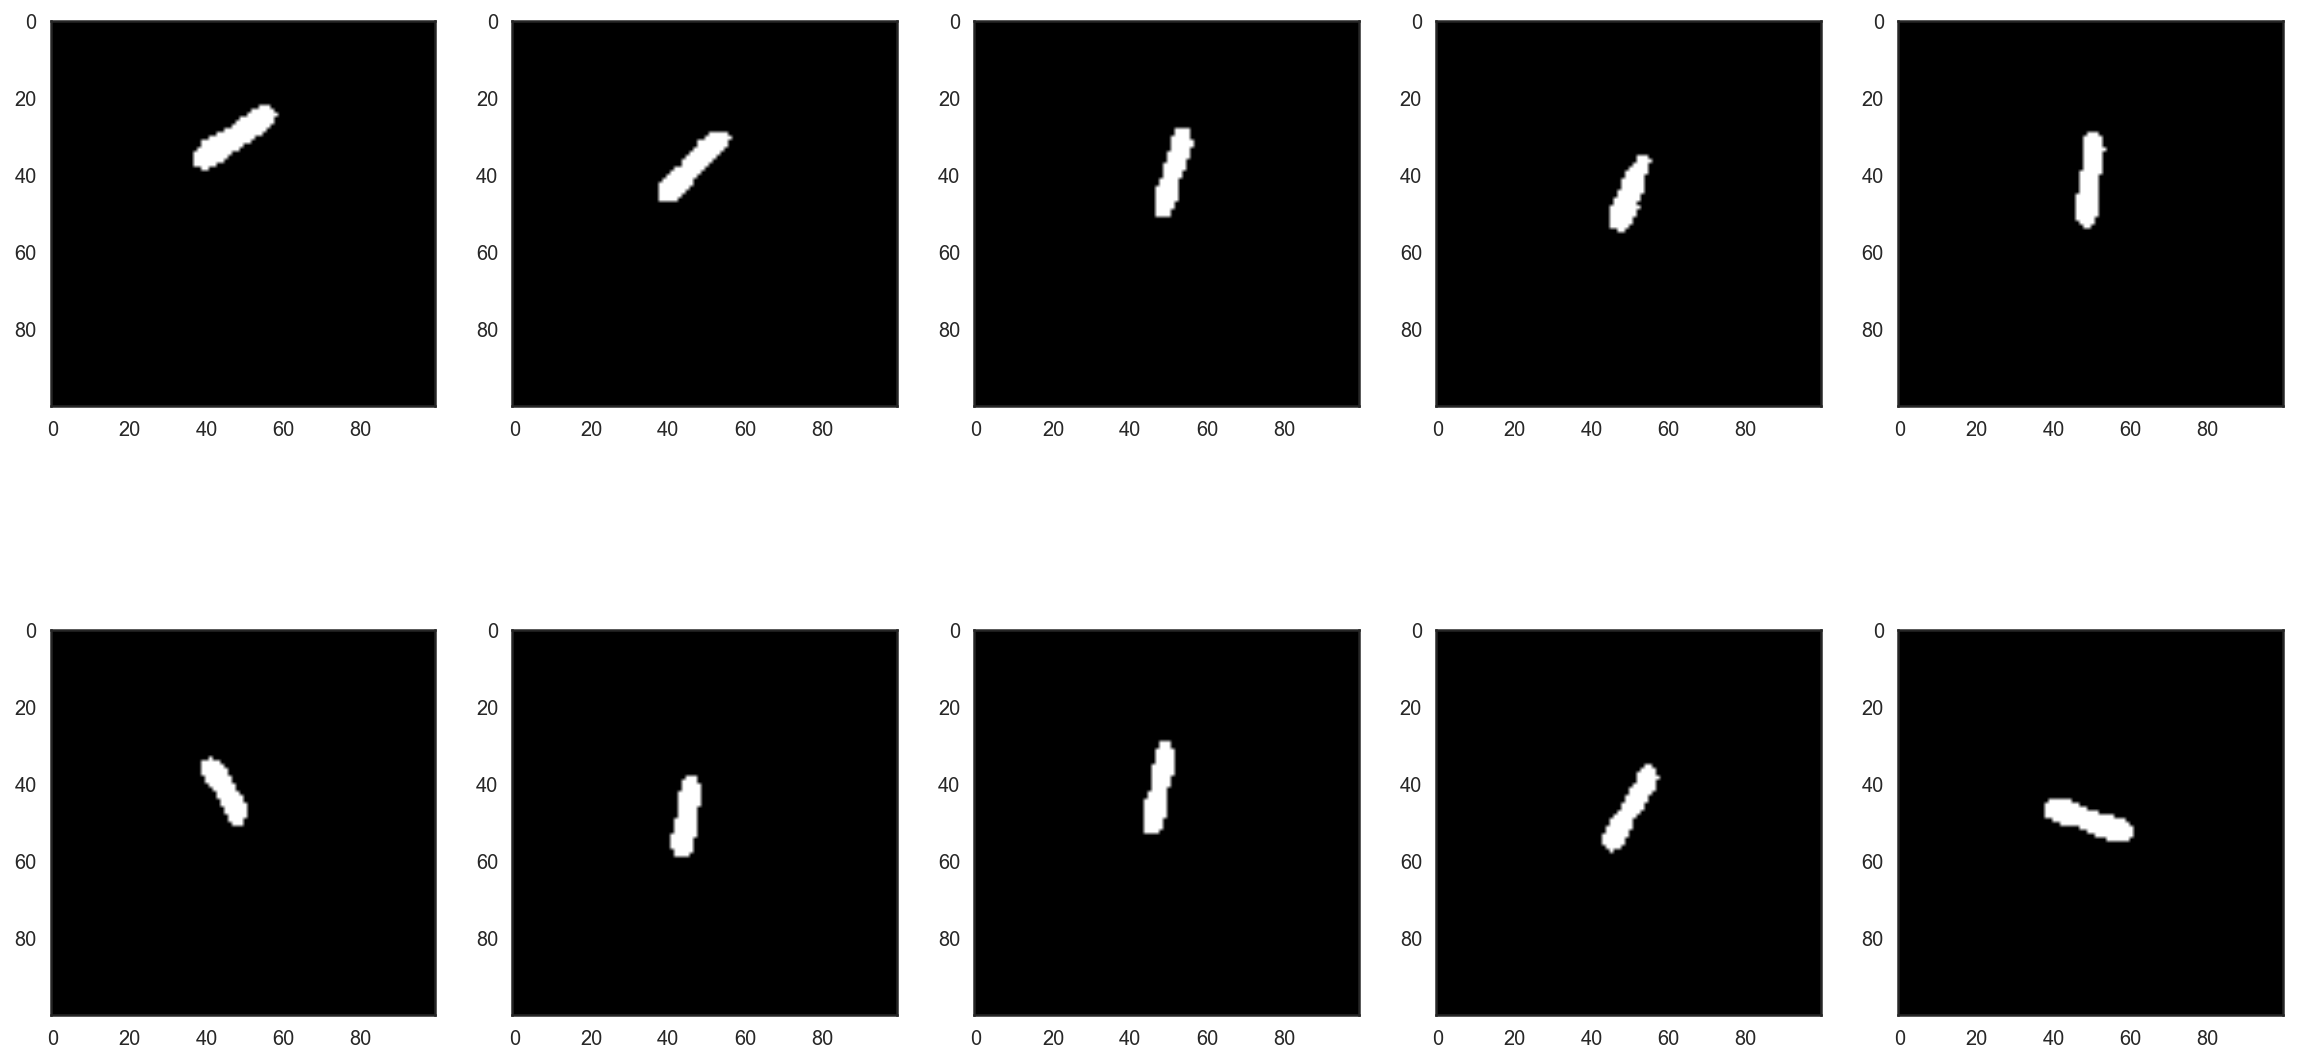

In [6]:
# Show indexed images for every 10 frames
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 5, figsize=(20,10))
    for i in range(10):
        if i < 5:
            ax[0, i].imshow(im_bw_labeled[i*10], cmap=plt.cm.gray)
        else:
            ax[1, i%5].imshow(im_bw_labeled[i*10], cmap=plt.cm.gray)

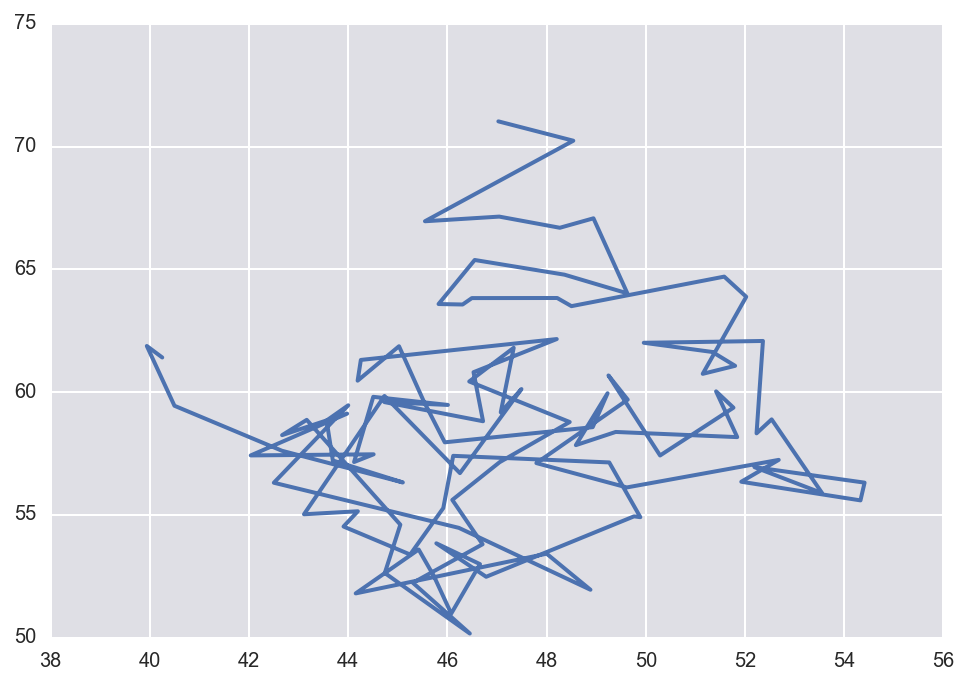

In [7]:
# Plot centroids to see how it moved
x = []
y = []
for i in range(frame):
    x.append(centroid[i][1])
    y.append(101 - centroid[i][0])
plt.plot(x, y)

In [8]:
def compute_D(frame, centroid):
    """
    This function takes in total frame number and the centroid and returns the short and long diffusion constant (D)
    """
    short_D = [] # Empty list to store short diffusion constant
    long_D = [] # Empty list to store long diffusion constant
    travel_distance = [] # List to save the total travel distance of the particle. It will be used to calculate long time D

    # Obtain short diffusion constant(D), where D = <d^2> / (4t), where d is distance and t is time
    for i in np.arange(frame - 1):
        distance_squared = ((centroid[i][0] - centroid[i+1][0])**2 + (centroid[i][1] - centroid[i+1][1])**2) * (inter_pixel_distance)**2 # in nm^2
        short_D.append(distance_squared / (4*time))
        travel_distance.append(distance_squared)

    # Obtain long time D
    long_D = (sum(travel_distance) / frame) / (4*time)

    return short_D, long_D

short_D, long_D = compute_D(frame, centroid)

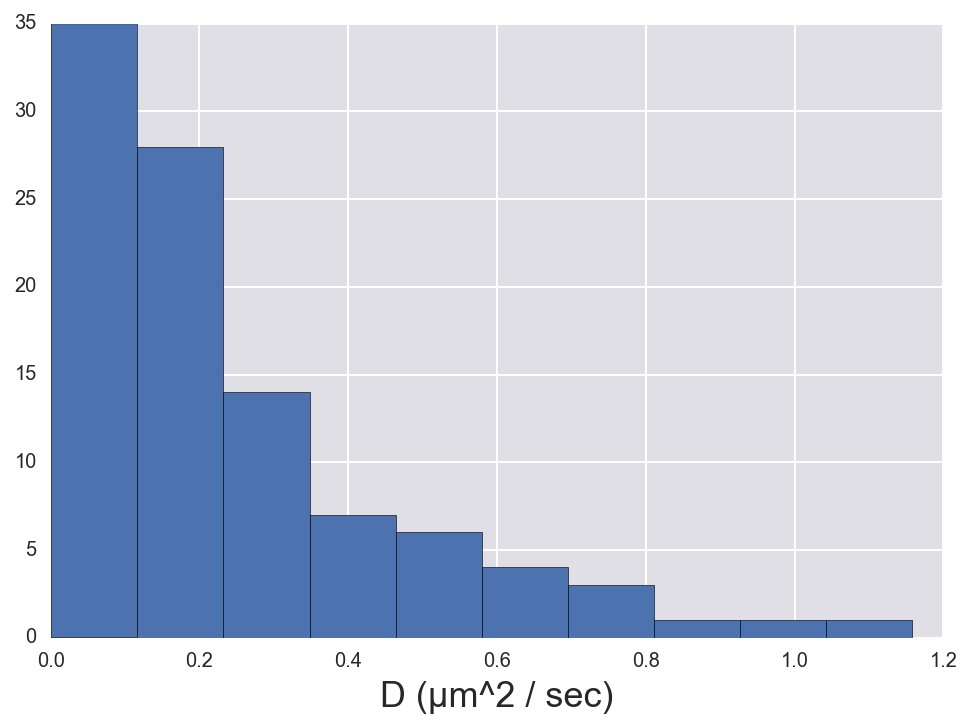

In [9]:
# Plot short D
short_D_um = []
for i in range(len(short_D)):
    short_D_um.append(short_D[i] / 1000000)
plt.hist(short_D_um);
plt.xlabel('D (µm^2 / sec)')

In [10]:
# Long D value in um
print(long_D / 1000000)

0.238269433507


In [11]:
# Change the units of short_D and long_D to µm^2
for i in range(len(short_D)):
    short_D[i] = short_D[i] / 1000000

In [12]:
# Rogers movie
# Get diffusion constant for a free floating bacteria in the movie from frame 390 to 423

# Directory containing the image files
data_dir = "/Users/Rio/Documents/2015-16_winter/PBoC@GIST/Project/16.9-neutrophil_chase.tiff"

# Information about the microscopy images
fps = 5
time = 1/fps # in seconds
frame = 423 - 390 + 1 # Number of frames

# Load the image as an ImageCollection
ic = skimage.io.ImageCollection(data_dir)

im_list = [] # Empty list to store images

# Only store frames that contain freely moving bacteria
for i in range(389, 423):
    im_list.append(ic[i])

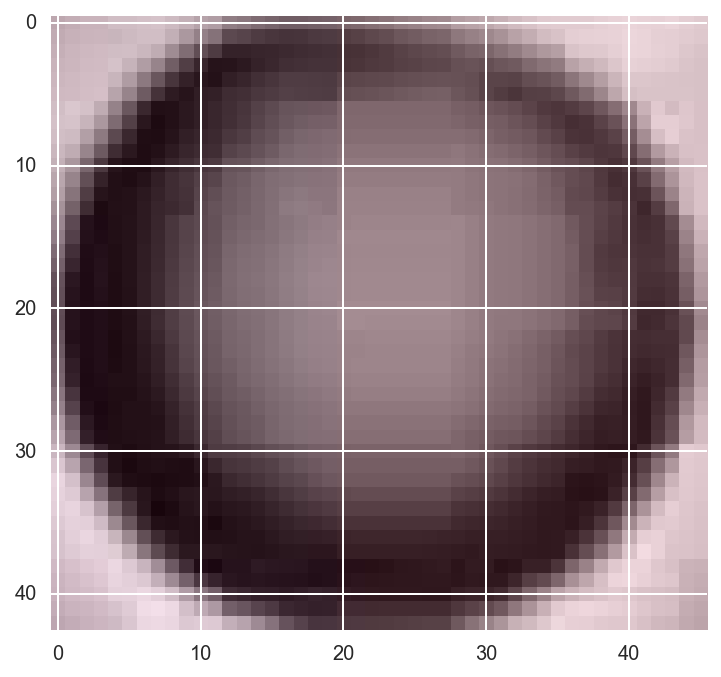

In [13]:
# There is no information about the interpixel distance of the microscope for this video
# However, a normal red blood cell is about 8 µm in diameter.
# Use this information to calculate the inter_pixel distance
im = ic[1][122:165, 236:282, :]
skimage.io.imshow(im)
inter_pixel_distance = 8 / (165 - 122 + 1) * 10**3 # in nm

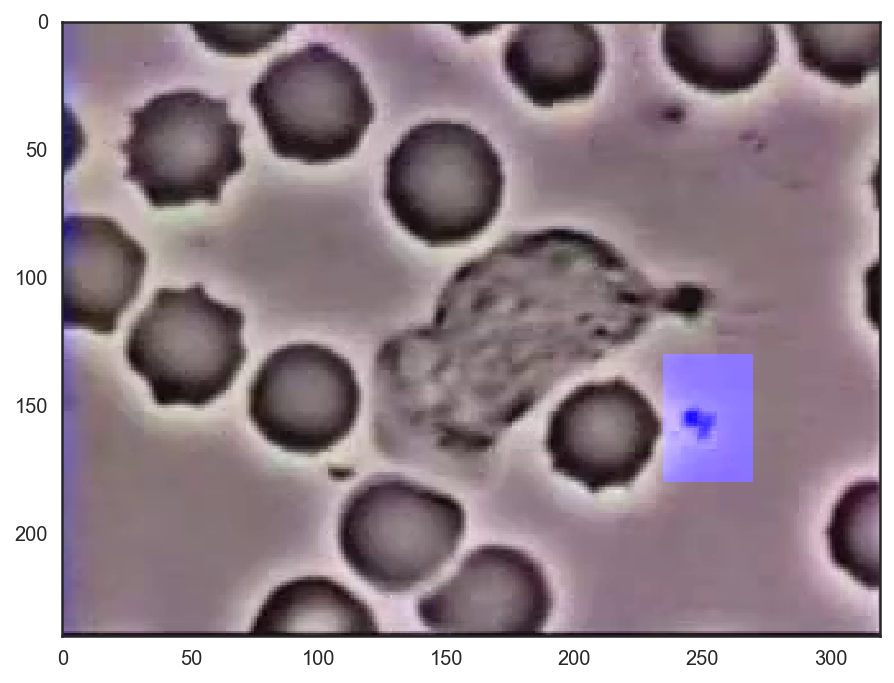

In [14]:
# Region of interest
im = im_list[0]

# Max out blue channel
im[130:180, 235:270, 2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [15]:
# Slice out the ROI and only the green channel
for i in range(frame):
    im_list[i] = im_list[i][130:180, 235:270, 1]

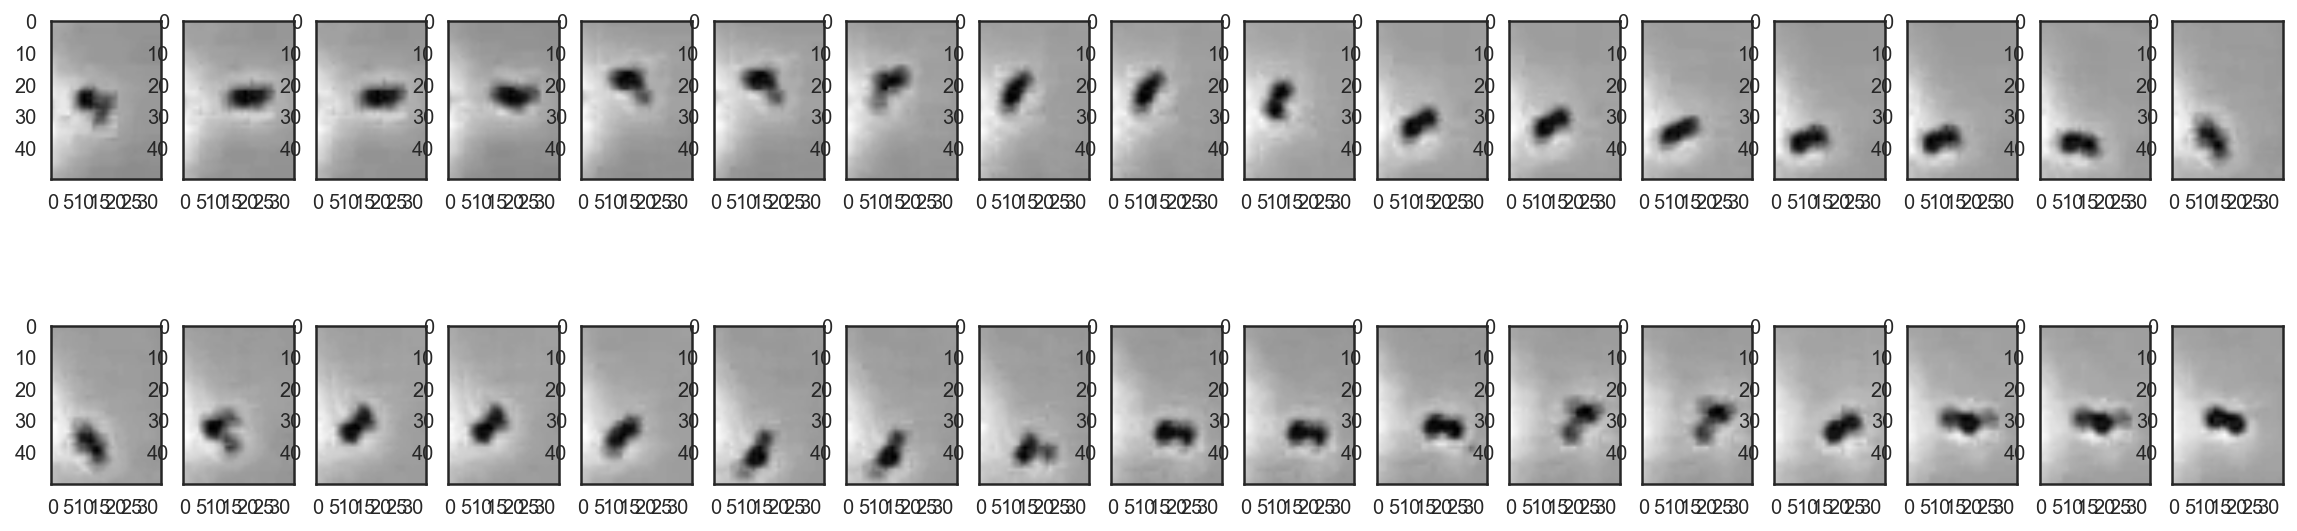

In [16]:
# See them for every frame before proceeding further
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 17, figsize=(20,5))
    for i in range(frame):
        if i < 17:
            ax[0, i].imshow(im_list[i], cmap=plt.cm.gray)
        else:
            ax[1, i%17].imshow(im_list[i], cmap=plt.cm.gray)

In [17]:
# Set threshold and get binary image, label and get centroid with regionprops
threshold = 100 # Obtained by looking at histograms of images
centroid = [] # Empty list to store centroids
im_bw_labeled_removed = [] # Empty list to store labeled images

for i in range(frame):
    im_bw_labeled = skimage.measure.label(im_list[i] < threshold)
    # Remove all the small objects
    im_bw_labeled_removed.append(skimage.morphology.remove_small_objects(im_bw_labeled, min_size=5))
    props = skimage.measure.regionprops(im_bw_labeled_removed[i])
    centroid.append(props[0].centroid)

/Users/Rio/anaconda/lib/python3.5/site-packages/skimage/morphology/misc.py:119: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warnings.warn("Only one label was provided to `remove_small_objects`. "


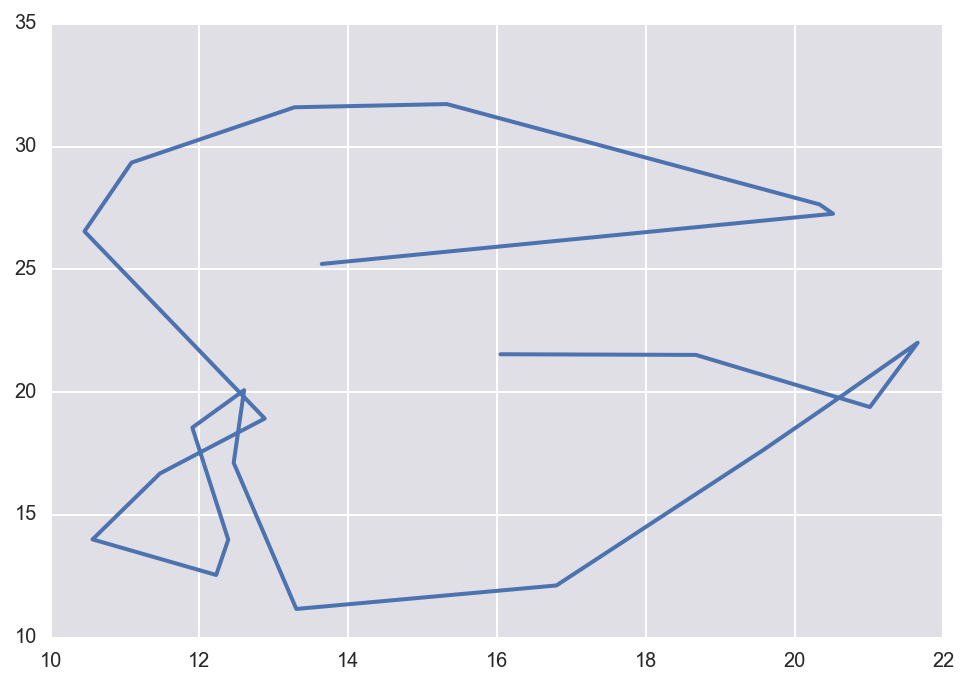

In [18]:
# Plot centroids to see how it moved
x = []
y = []
for i in range(frame):
    x.append(centroid[i][1])
    y.append(51 - centroid[i][0])
plt.plot(x, y)

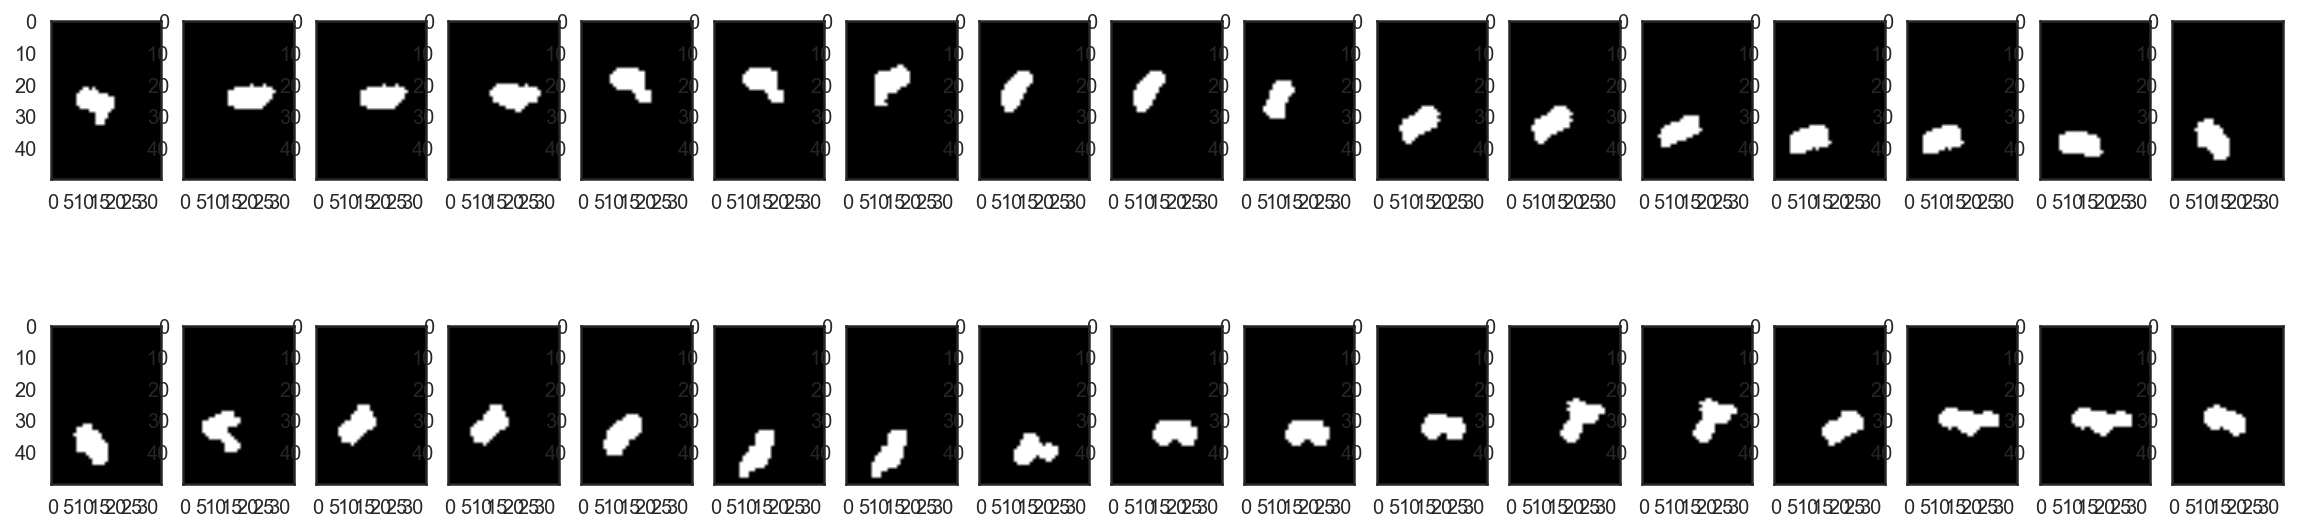

In [19]:
# See them for every frame before proceeding further
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 17, figsize=(20,5))
    for i in range(frame):
        if i < 17:
            ax[0, i].imshow(im_bw_labeled_removed[i], cmap=plt.cm.gray)
        else:
            ax[1, i%17].imshow(im_bw_labeled_removed[i], cmap=plt.cm.gray)

In [20]:
# Compute the short and long D
short_D, long_D = compute_D(frame, centroid)

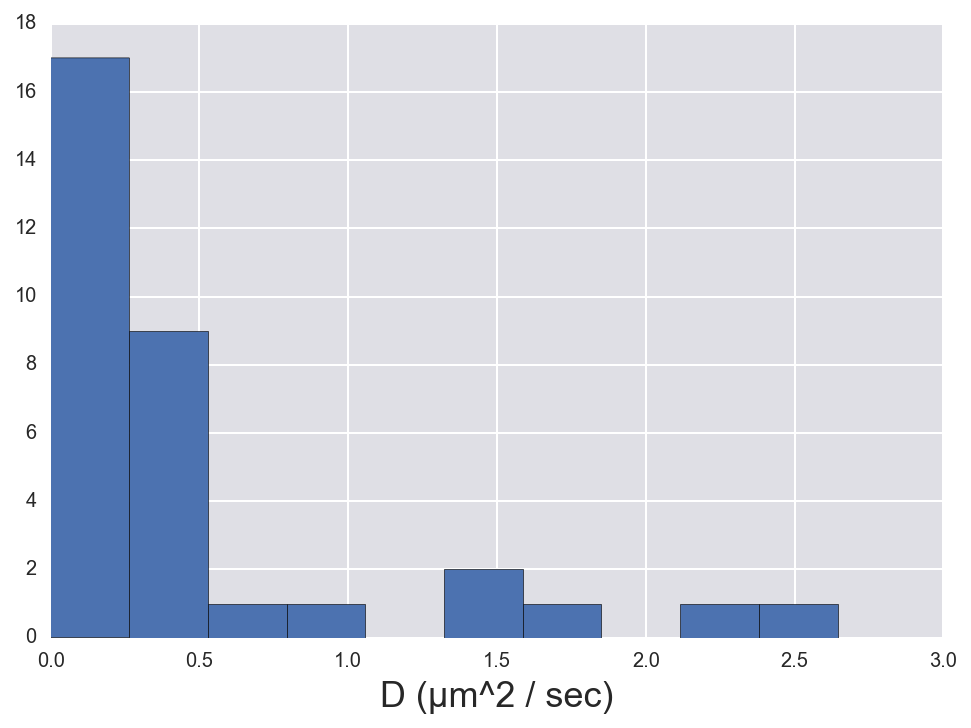

In [21]:
# Plot short D
short_D_um = []
for i in range(len(short_D)):
    short_D_um.append(short_D[i] / 1000000)
plt.hist(short_D_um);
plt.xlabel('D (µm^2 / sec)')

In [22]:
# Long D value in um
print(long_D / 1000000)

0.434833352156


Now analyze the bacteria that looks like it is being chased by the neutrophil

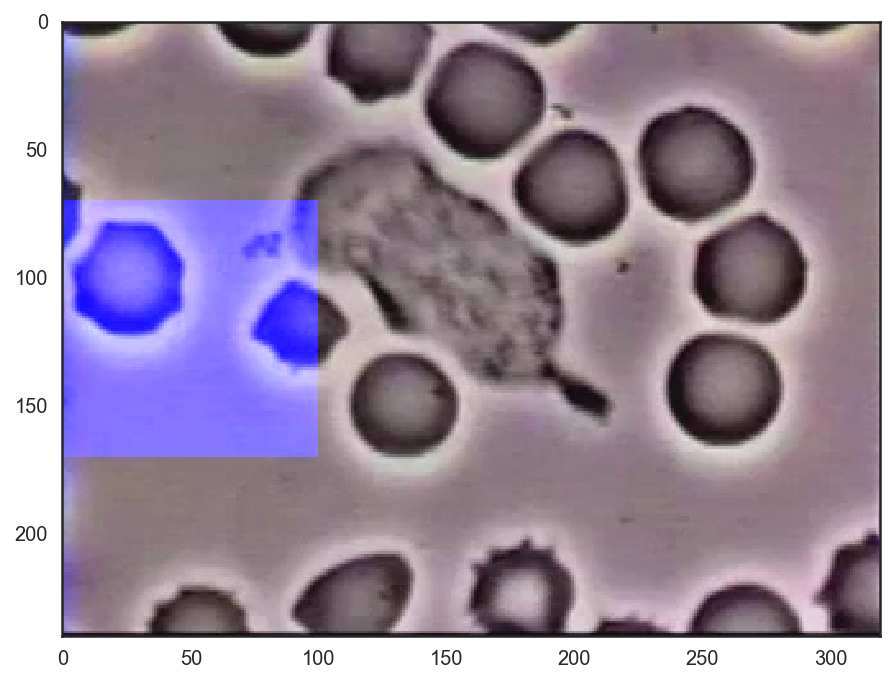

In [23]:
# Region of interest
im = ic[256]

# Max out blue channel
im[70:170, 0:100, 2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [24]:
# Frames 257 - 291
frame = 291 - 257 + 1
im_list = [] # Empty list to store images

# Only store frames that contain freely moving bacteria
for i in range(256, 291):
    im_list.append(ic[i])

# Slice out the ROI and only the green channel
for i in range(frame):
    im_list[i] = im_list[i][70:170, 0:100, 1]

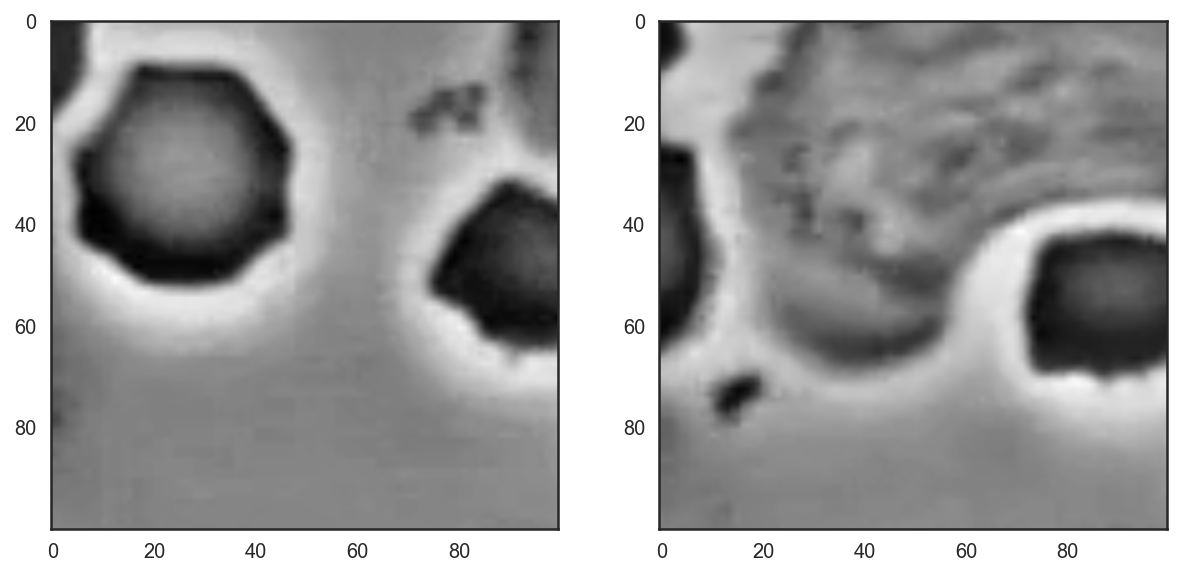

In [25]:
# See the first and the last frame
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(im_list[0], cmap=plt.cm.gray)
    ax[1].imshow(im_list[frame - 1], cmap=plt.cm.gray)

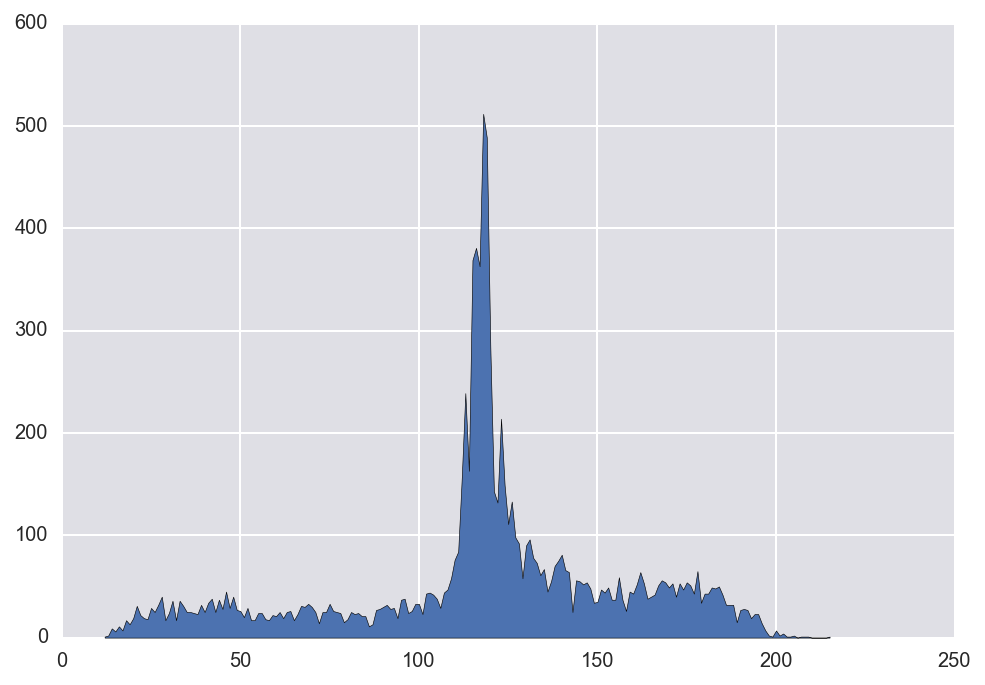

In [26]:
# Histogram of pixel values
hist, bins = skimage.exposure.histogram(im_list[0])
plt.fill_between(bins, hist)

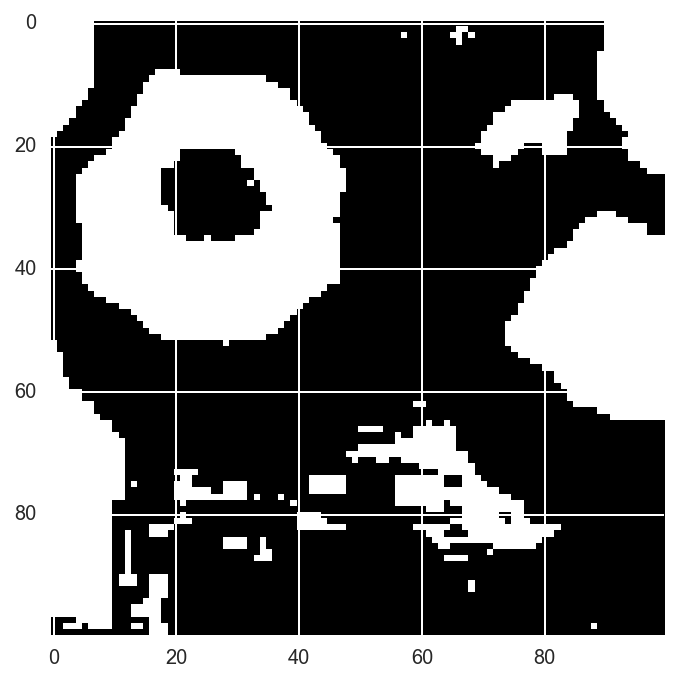

In [27]:
# Plot the image to guess a good threshold
skimage.io.imshow(im_list[0] < 115)

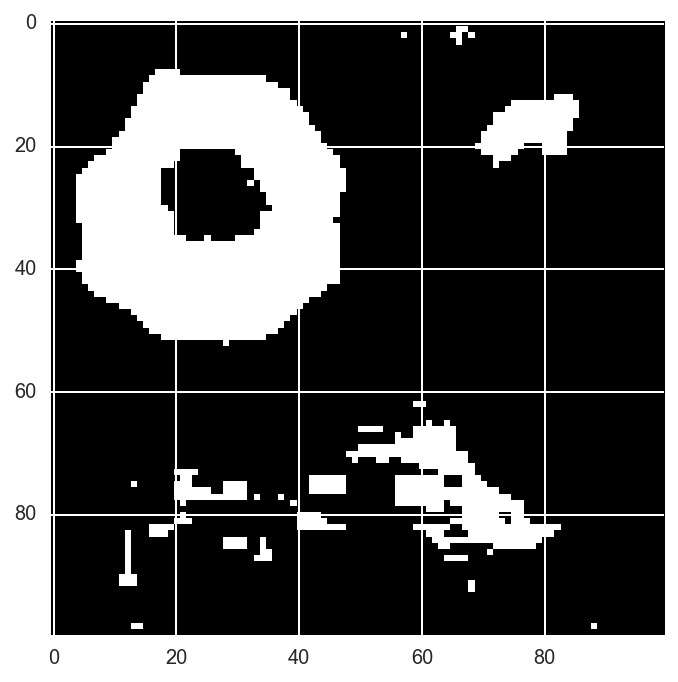

In [28]:
# Clear the border
border_cleared = skimage.segmentation.clear_border(im_list[0] < 115)
skimage.io.imshow(border_cleared)

In [29]:
# Set threshold, clear the border, remove small objects and then label
threshold = 115 # Obtained by looking at histograms of images
im_bw_border_removed_labeled = [] # Empty list to store labeled images

for i in range(frame):
    im_bw_border = skimage.segmentation.clear_border(im_list[i] < threshold)
    # Remove all the small objects
    im_bw_border_removed = skimage.morphology.remove_small_objects(im_bw_border, min_size=53)
    im_bw_border_removed_labeled.append(skimage.measure.label(im_bw_border_removed))

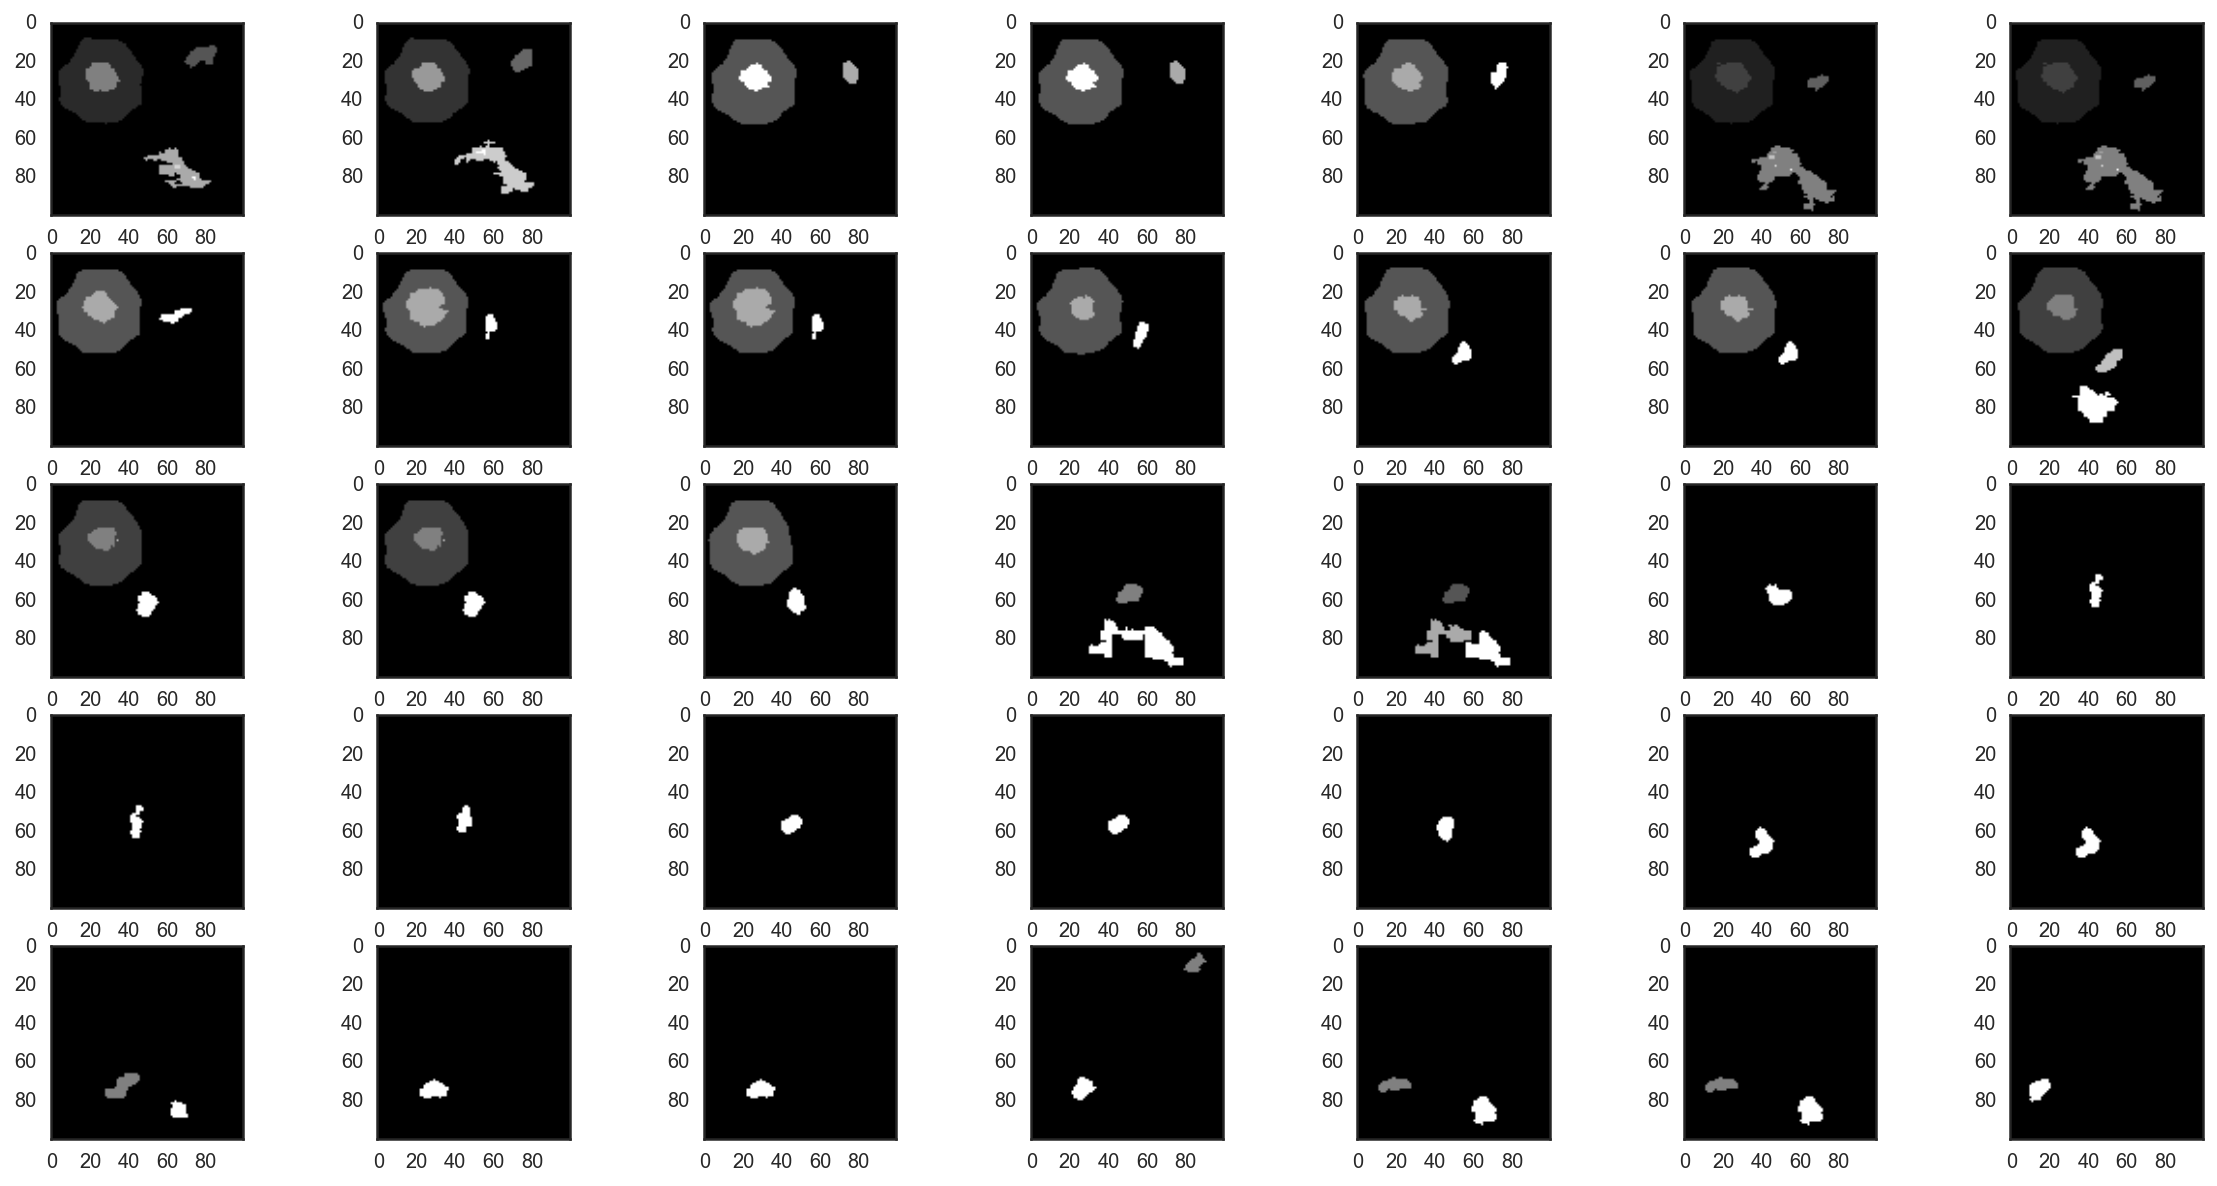

In [30]:
# Show preliminary segmentation
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 7, figsize=(20,10))
    row = -1
    for i in range(frame):
        if i%7 == 0:
            row += 1
        ax[row, i%7].imshow(im_bw_border_removed_labeled[i], cmap=plt.cm.gray)

In [31]:
# Apply an area filter
bacteria = [] # Empty list to store binary bacteria image
for i in range(len(im_bw_border_removed_labeled)):
    for j in range(1, im_bw_border_removed_labeled[i].max() + 1):
        props = skimage.measure.regionprops(im_bw_border_removed_labeled[i] == j)
        # 63 was hard coded to eliminate one blob
        if (props[0].area > 50) and (props[0].area < 122) and (props[0].area != 63):
            bacteria.append(im_bw_border_removed_labeled[i] == j)

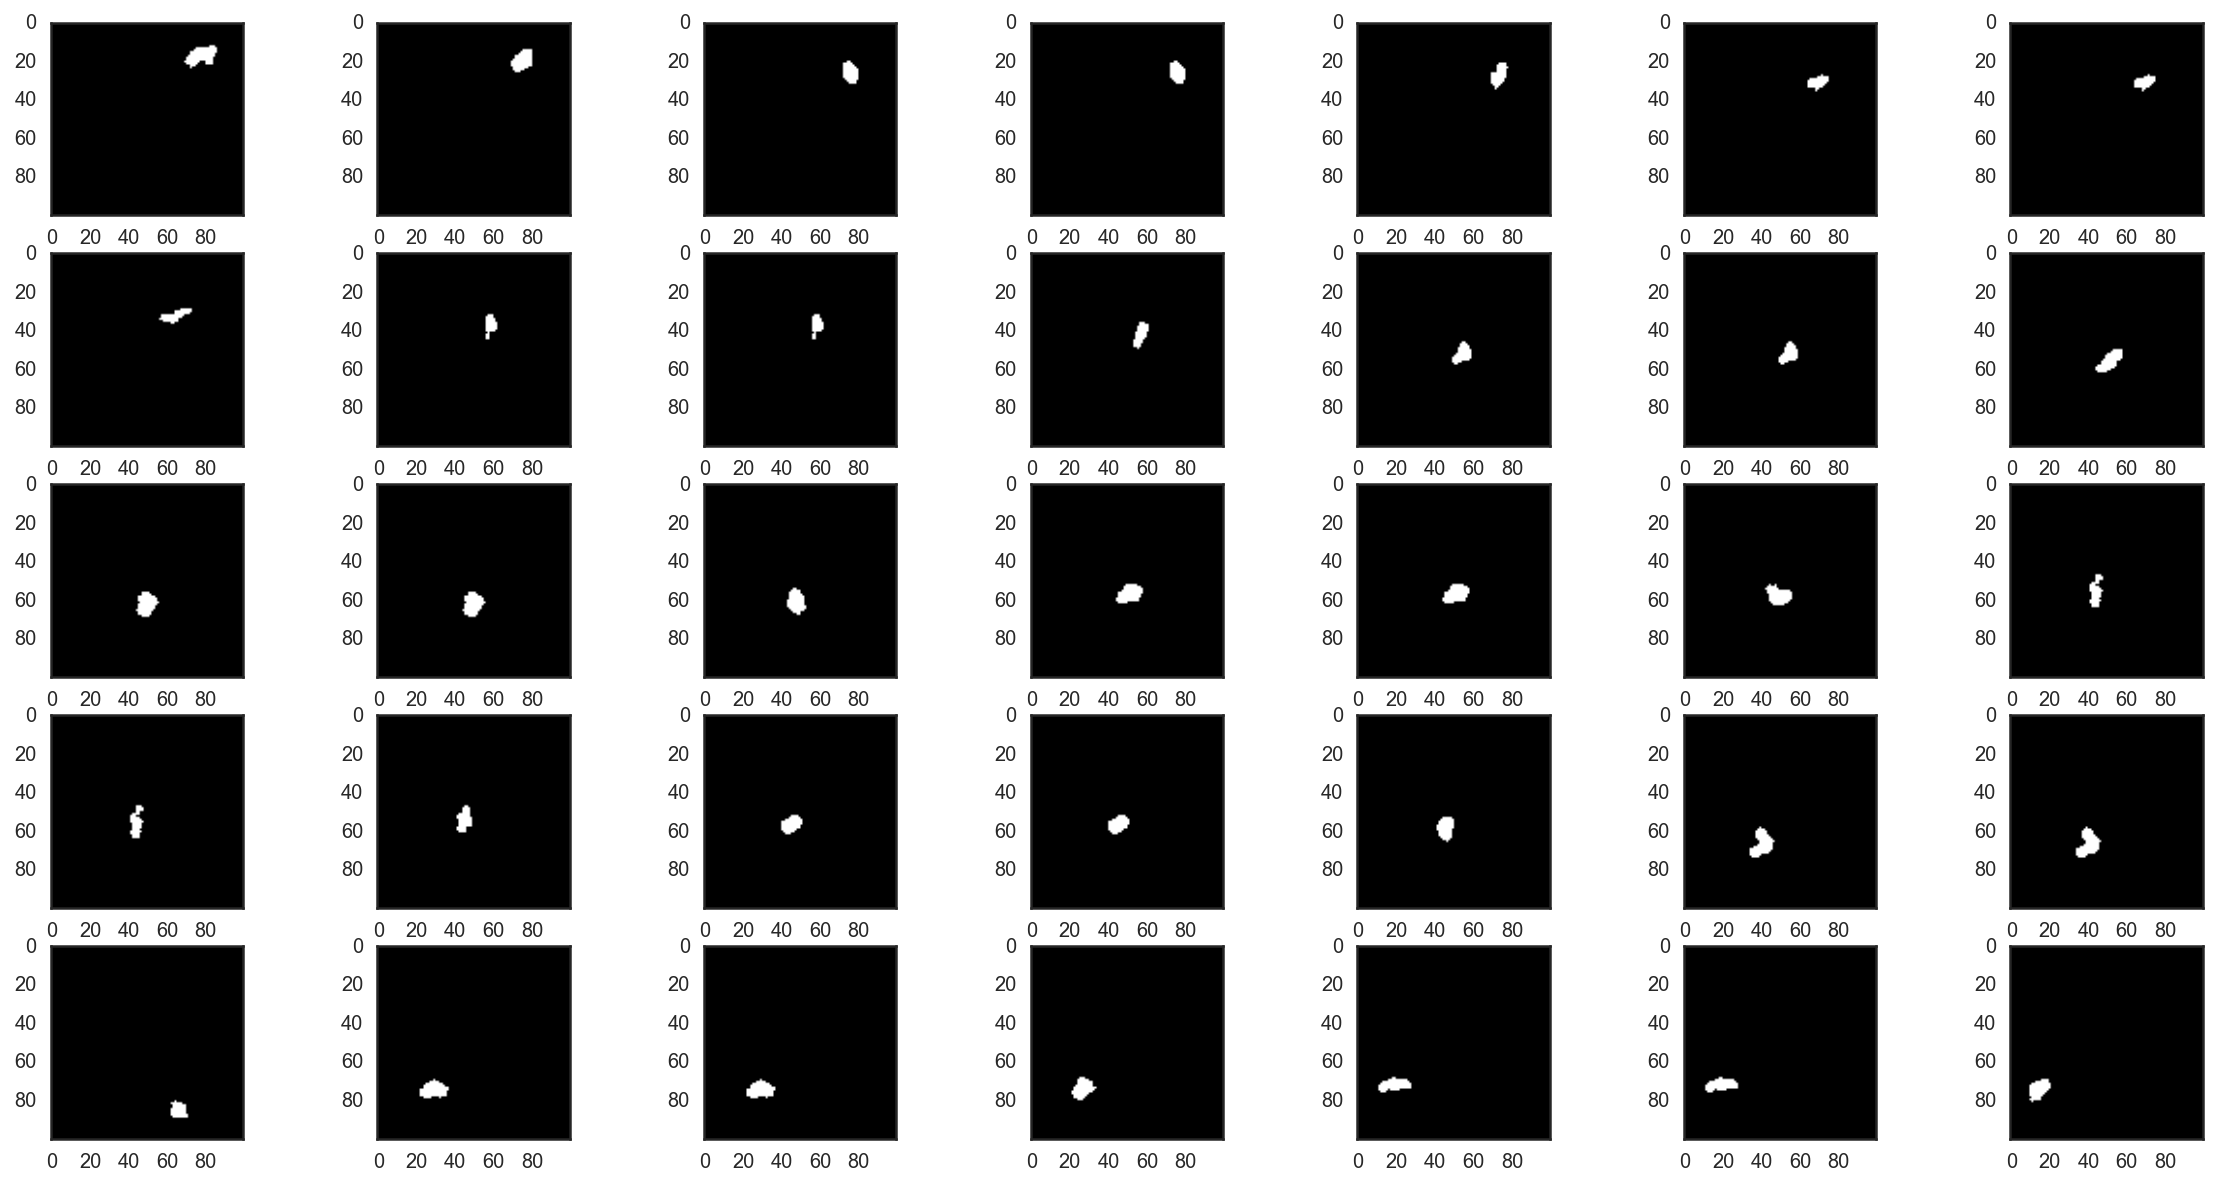

In [32]:
# Plot the segmented bacteria
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 7, figsize=(20,10))
    row = -1
    for i in range(frame):
        if i%7 == 0:
            row += 1
        ax[row, i%7].imshow(bacteria[i], cmap=plt.cm.gray)

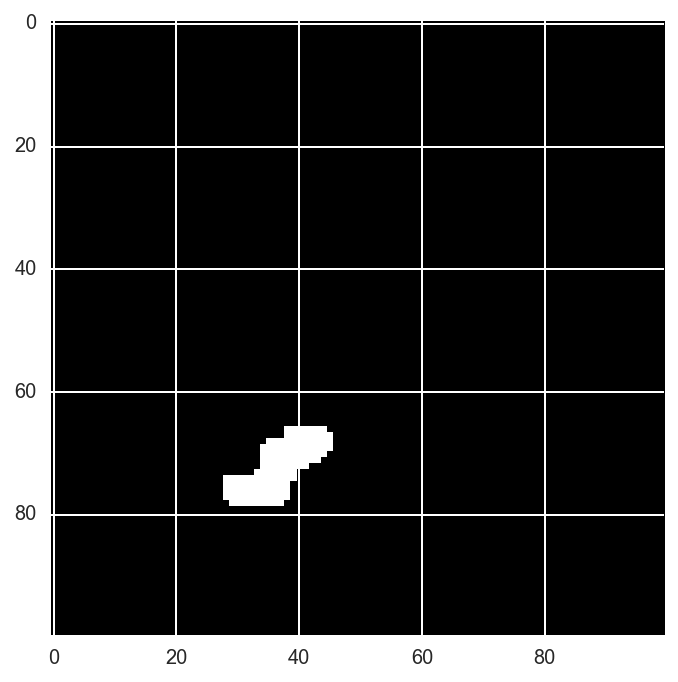

In [33]:
# Wrong object was selected by the area filter above
# Change the frame 29 with bacteria
bacteria[28] = im_bw_border_removed_labeled[28] == 1
skimage.io.imshow(bacteria[28])

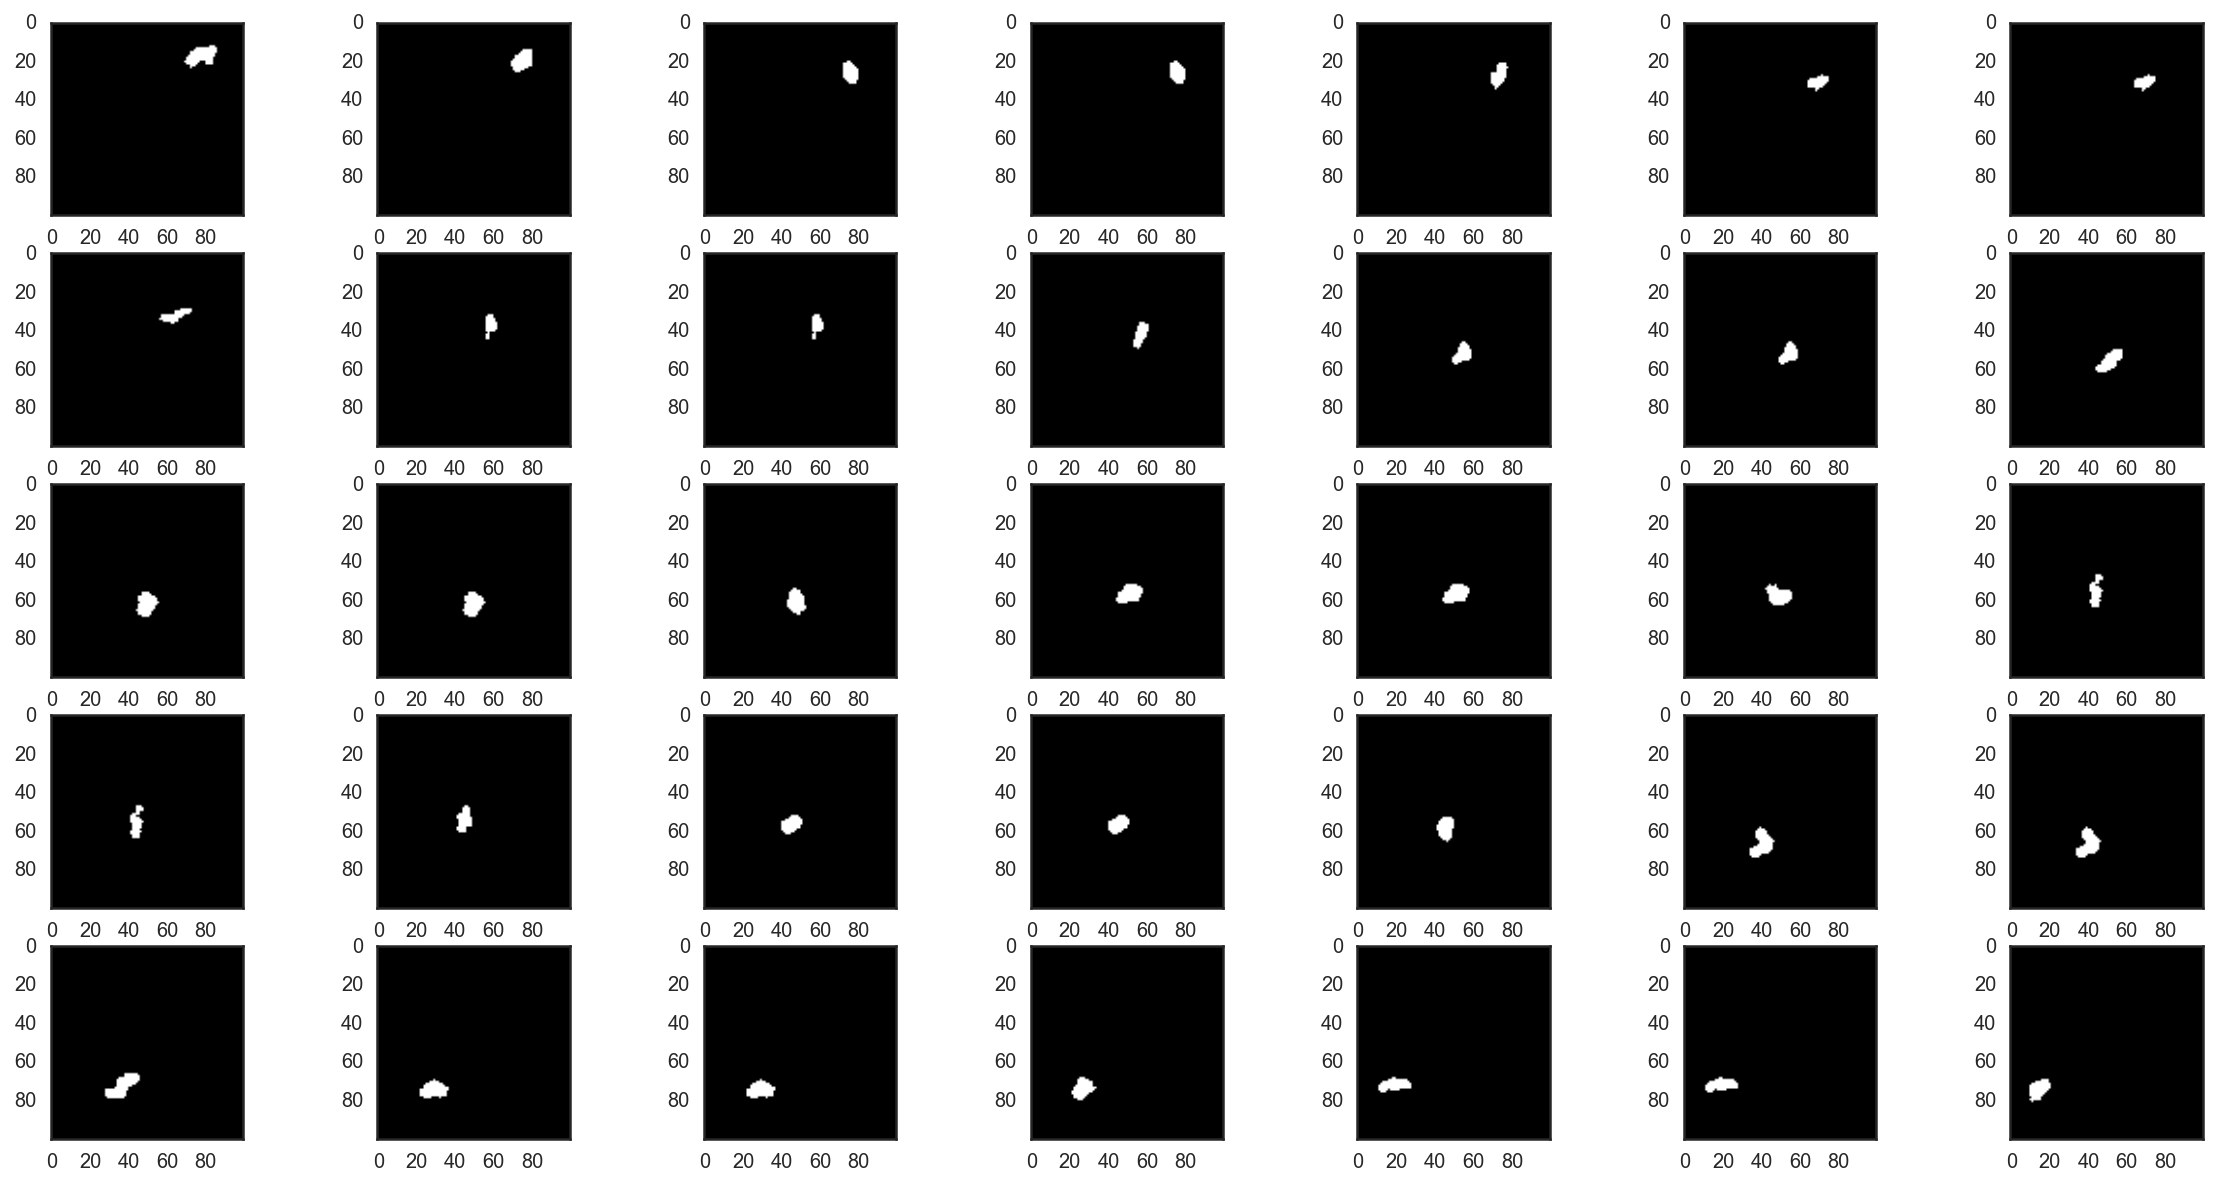

In [34]:
# Plot it again with the frame 29 swapped out
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 7, figsize=(20,10))
    row = -1
    for i in range(frame):
        if i%7 == 0:
            row += 1
        ax[row, i%7].imshow(bacteria[i], cmap=plt.cm.gray)

In [35]:
# Let's track this maverick
centroid = [] # Empty list to store centroids
for i in range(frame):
    props = skimage.measure.regionprops(bacteria[i])
    centroid.append(props[0].centroid)

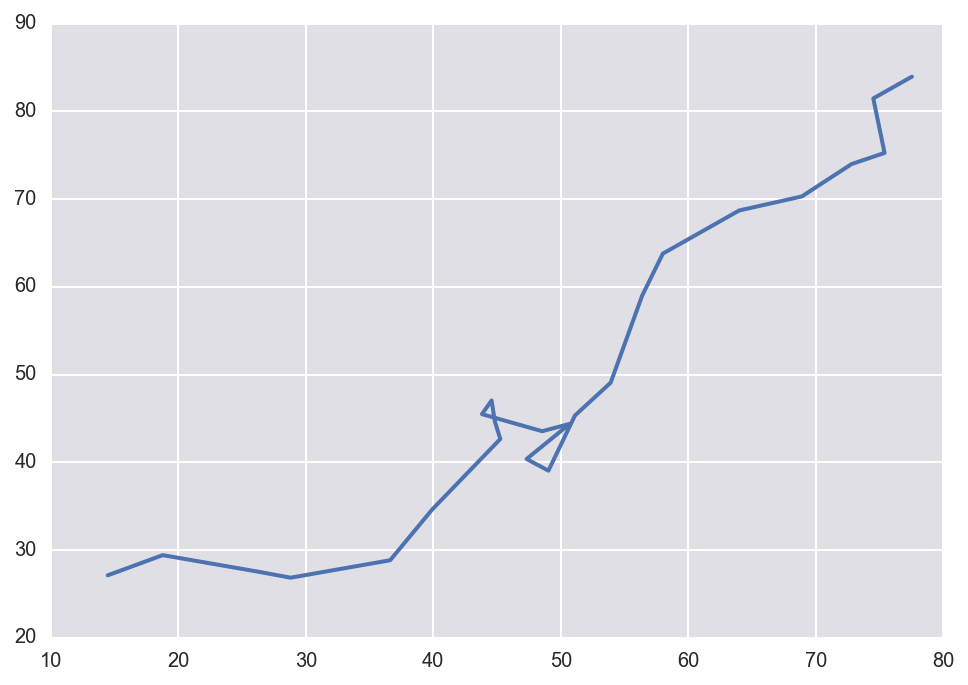

In [36]:
# Plot the centroid
x = []
y = []
for i in range(frame):
    x.append(centroid[i][1])
    y.append(101 - centroid[i][0])
plt.plot(x, y)

In [37]:
# Compute the short and long D
short_D, long_D = compute_D(frame, centroid)

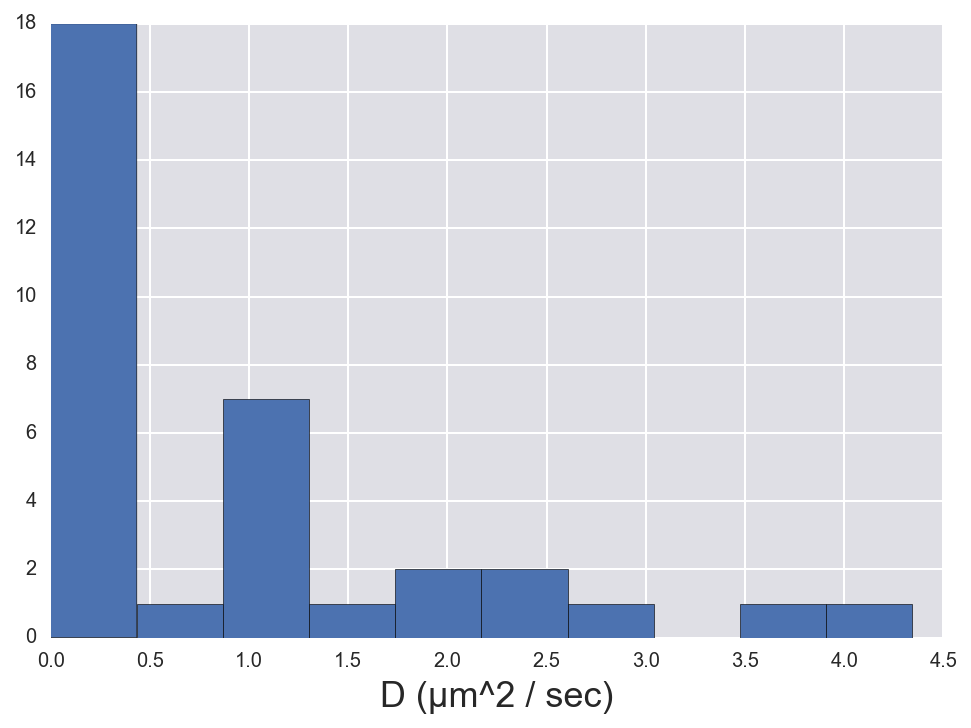

In [38]:
# Plot short D
short_D_um = []
for i in range(len(short_D)):
    short_D_um.append(short_D[i] / 1000000)
plt.hist(short_D_um);
plt.xlabel('D (µm^2 / sec)')

In [39]:
# Long D value in um
print(long_D / 1000000)

0.880473473186
